## Notebook 2: Adding Building ID to Complaints, Historic Complaints, and 311 Data

The city data provide address and coordinates, which do not always match a specific building in the Master_Address.csv file. I am interested in building, and not address (a building can have multiple addresses, as in appartment building), so I need to tie the snow/ice events to specific buildings.

This notebook explores the code to tie snow/ice events with building ID using address and location data, as available. 

The snow/ice events come from 3 datasets:

    Snow_Ice_Sidewalk_Ordinance_Violations.csv
    Unshoveled_Icy_Sidewalk_Complaints.csv
    Commonwealth_Connect_Service_Requests.csv 
    
### Tickets feature: Snow_Ice_Sidewalk_Ordinance_Violations.csv


In [40]:
# Starting with Commonwealth_Connect_Service_Requests.csv
import pandas as pd
import numpy as np

tickets = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/external/Snow_Ice_Sidewalk_Ordinance_Violations.csv')

tickets

,TICKET NUMBER,TICKET TYPE,OFFENSE DATE,ISSUANCE DATE,TIME OF DAY,TICKET LOCATION
0,17189,Snow & Ice,02/25/2011,02/28/2011,8:27,"96 FOSTER ST\nCambridge, MA\n(42.376162139, -7..."
1,16819,Snow & Ice,02/07/2011,02/08/2011,12:08,"94-98 PLEASANT ST\nCambridge, MA\n(42.36185930..."
2,17396,Snow & Ice,02/14/2013,02/15/2013,11:42,"406 NORFOLK ST\nCambridge, MA\n(42.374172573, ..."
3,9669,Snow & Ice,02/26/2008,02/26/2008,12:00,"38 SACRAMENTO ST\nCambridge, MA\n(42.382551595..."
4,1001,Snow & Ice,12/29/2010,12/29/2010,12:45,"235 THIRD ST\nCambridge, MA\n(42.367117597, -7..."
...,...,...,...,...,...,...
6540,21222,Snow & Ice,01/24/2019,04/17/2019,1899-12-31T12:10:00.000,"6 STANDISH ST\nCambridge, MA\n(42.381472, -71...."
6541,21229,Snow & Ice,02/14/2019,04/17/2019,1899-12-31T10:43:00.000,"12 TUFTS ST\nCambridge, MA\n(42.357266, -71.11..."
6542,21371,Snow & Ice,03/07/2019,04/17/2019,1899-12-31T11:38:00.000,"156 THORNDIKE ST\nCambridge, MA\n(42.370299, -..."
6543,21239,Snow & Ice,02/14/2019,04/17/2019,1899-12-31T10:48:00.000,"338 HARVARD ST\nCambridge, MA\n(42.370593, -71..."


In [41]:
tickets['OFFENSE DATE'] = pd.to_datetime(tickets['OFFENSE DATE'],infer_datetime_format=True)
tickets['OFFENSE DATE'] = tickets['OFFENSE DATE'].dt.date

print('ticket dates:',min(tickets['OFFENSE DATE']),'to',max(tickets['OFFENSE DATE']))

ticket dates: 2007-12-04 to 2019-03-07


=> there are 6545 tickets, between 2007 and 2019. These will be our validation data.

Where are these located in the city?

In [42]:
# extracting the lat/lon info to answer the question of where they are located:
extract = tickets['TICKET LOCATION']

extract = extract.apply(lambda x: x.split('(',1)[1])
extract = extract.apply(lambda x: x.split(')',1)[0])

tickets['lat'] = extract.apply(lambda x: x.split(',',1)[0])
tickets['lon'] = extract.apply(lambda x: x.split(',',1)[1])

print('Range of Latitudes for ticket coordinates:',tickets['lat'].min(),tickets['lat'].max())
print('Range of Longitudes for ticket coordinates:',tickets['lon'].min(),tickets['lon'].max())

tickets['lat'] = tickets['lat'].astype('float') 
tickets['lon'] = tickets['lon'].astype('float') 

tickets.dtypes

Range of Latitudes for ticket coordinates: 42.353576117 42.402125568
Range of Longitudes for ticket coordinates:  -71.071717276  -71.160199931


TICKET NUMBER        int64
TICKET TYPE         object
OFFENSE DATE        object
ISSUANCE DATE       object
TIME OF DAY         object
TICKET LOCATION     object
lat                float64
lon                float64
dtype: object

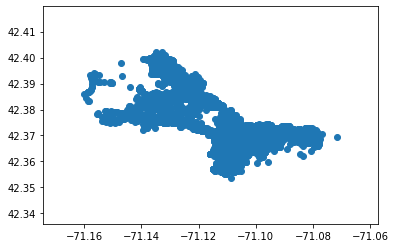

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.scatter(tickets['lon'],tickets['lat'])

The figure above shows a dot for each location that received a ticket in between 2007 and 2019. The tickets are distributed all over the city! 



The next stage is to tie these locations to an address and an identifier in the BldgID2WeatherIdentifier.csv file. Here I'm using a trick to make the code tun a little faster: only searching within a certain radius.

In [43]:
identifierLocation = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/processed/BldgID2WeatherIdentifier.csv')

from geopy.distance import geodesic
def find_nearest_building(df,latI,lonI):
    minDist = 4000
    for i in range(0,df.shape[0]):
        lat = df['lat'].iloc[i]
        lon = df['lon'].iloc[i]
        dist = geodesic([lat,lon],[latI,lonI]).meters
        if dist<minDist:
            minDist = dist
            nearestBuildingInDf = i
    return nearestBuildingInDf

identifierLocation.keys()

Index(['Unnamed: 0', 'Building ID', 'lat', 'lon', 'identifier'], dtype='object')

In [39]:
# running over the tickets, cutting part of the identifierLocation DataaFrame close to each 
# ticket location, and finding the closest match building wise (first 10 tickets, rest in code):

lat_radius=abs(tickets['lat'].min()-tickets['lat'].max())/25
lon_radius = abs(tickets['lon'].min()-tickets['lon'].max())/25

tickets_feature = pd.DataFrame()
for i in range(0,10):
    lat = tickets['lat'].iloc[i]
    lon = tickets['lon'].iloc[i]
    minLat = lat-lat_radius
    maxLat = lat+lat_radius
    minLon = lon-lon_radius
    maxLon = lon+lon_radius
    df = identifierLocation[identifierLocation['lat']<maxLat]
    df = df[df['lat']>minLat]
    df = df[df['lon']<maxLon]
    df = df[df['lon']>minLon]
    #print(df.shape[0])
    # df now contains all the buildings withing the given lat/lon circle around the ticket location.
    # one of these buildings is the one that received the ticket:
    nearestBuildingIloc = find_nearest_building(df,lat,lon)
    tmp = df.iloc[nearestBuildingIloc]
    tmp['date'] = tickets['OFFENSE DATE'].iloc[i]
    tickets_feature = tickets_feature.append(tmp)
    

The full tickets dataset was processed with python directly, with the build_features.py script. Examining the results:

In [44]:
tickets_feature=pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/interim/tickets_label.csv')


In [46]:
tickets_feature

,Unnamed: 0,Building ID,Unnamed: 0.1,date,identifier,label,lat,lon
0,3865,329-19,3865.0,2011-02-25,285.0,1.0,42.3761,-71.1309
1,6127,97-21,6127.0,2011-02-07,480.0,1.0,42.3620,-71.1107
2,1490,457-11,1490.0,2013-02-14,610.0,1.0,42.3742,-71.0955
3,7074,623-19,7074.0,2008-02-26,417.0,1.0,42.3823,-71.1161
4,9762,337-32,9762.0,2010-12-29,748.0,1.0,42.3671,-71.0817
...,...,...,...,...,...,...,...,...
6540,10205,451-18,10205.0,2019-01-24,201.0,1.0,42.3815,-71.1388
6541,7261,22-5,7261.0,2019-02-14,455.0,1.0,42.3573,-71.1127
6542,8149,74-30,8149.0,2019-03-07,692.0,1.0,42.3704,-71.0854
6543,1405,302-2,1405.0,2019-02-14,476.0,1.0,42.3707,-71.1089


### Historic Complaints: Unshoveled_Icy_Sidewalk_Complaints.csv

In [47]:
# Starting with Commonwealth_Connect_Service_Requests.csv
import pandas as pd
import numpy as np

complaintsH = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/external/Unshoveled_Icy_Sidewalk_Complaints.csv')

complaintsH


,Request ID,Status,Action Type,Address,Date Submitted,Date Completed,Platform,Submitted By
0,REQ477458,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"26 Sparks St\nCambridge, MA\n(42.375863762, -7...",02/18/2014 04:06:00 PM,02/20/2014 07:49:00 PM,NaN,web-services
1,REQ472435,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"Irving St\nCambridge, MA\n(42.378252519, -71.1...",12/18/2013 12:27:00 PM,12/19/2013 05:34:00 PM,NaN,web-services
2,REQ476591,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"Huron Ave\nCambridge, MA\n(42.380560528, -71.1...",02/10/2014 02:09:00 PM,02/12/2014 02:28:00 PM,NaN,web-services
3,REQ397662,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"Upton St\nCambridge, MA\n(42.362748703, -71.10...",01/23/2012 04:22:00 PM,01/23/2012 07:34:00 PM,NaN,web-services
4,REQ518551,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"19 Irving St\nCambridge, MA\n(42.375267009, -7...",02/17/2015 02:10:00 PM,02/24/2015 02:58:00 PM,NaN,web-services
...,...,...,...,...,...,...,...,...
4849,REQ519218,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"125 Hampshire St\nCambridge, MA\n(42.370263373...",02/20/2015 05:46:00 PM,02/23/2015 04:22:00 PM,NaN,web-services
4850,REQ520250,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"80 River St\nCambridge, MA\n(42.364292343, -71...",02/27/2015 12:16:00 AM,02/27/2015 02:51:00 PM,NaN,web-services
4851,REQ521301,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"37 Cushing St\nCambridge, MA\n(42.375808982, -...",03/07/2015 04:09:00 PM,03/12/2015 04:51:00 PM,iOS,web-services
4852,REQ439349,Closed,Enforce Snow/Ice Ordinance - Sidewalk Not Shov...,"2336 Massachusetts 2A\nCambridge, MA\n(42.3959...",02/15/2013 04:33:00 PM,02/19/2013 06:12:00 PM,Android,web-services


There are 4854 complaints in this dataset. (I merge them later on with the 311 dataset once both are in the same format).

Again we have the same issue with the address and the lat/lon coordinates condensed to the same field. Dealing with that first, using the same functions as earlier:

In [48]:
complaintsH['OFFENSE DATE'] = pd.to_datetime(tickets['OFFENSE DATE'],infer_datetime_format=True)
complaintsH['OFFENSE DATE'] = complaintsH['OFFENSE DATE'].dt.date

print('Complaints dates:',min(complaintsH['OFFENSE DATE']),'to',max(complaintsH['OFFENSE DATE']))


Complaints dates: 2007-12-04 to 2017-03-21


In [51]:
extract = complaintsH['Address']

extract = extract.apply(lambda x: x.split('(',1)[1])
extract = extract.apply(lambda x: x.split(')',1)[0])

complaintsH['lat'] = extract.apply(lambda x: x.split(',',1)[0])
complaintsH['lon'] = extract.apply(lambda x: x.split(',',1)[1])

print('Range of Latitudes for ticket coordinates:',complaintsH['lat'].min(),complaintsH['lat'].max())
print('Range of Longitudes for ticket coordinates:',complaintsH['lon'].min(),complaintsH['lon'].max())

complaintsH['lat'] = complaintsH['lat'].astype('float') 
complaintsH['lon'] = complaintsH['lon'].astype('float') 

complaintsH.dtypes

Range of Latitudes for ticket coordinates: 42.353477356 42.403020698
Range of Longitudes for ticket coordinates:  -71.070146567  -71.160697179


Request ID         object
Status             object
Action Type        object
Address            object
Date Submitted     object
Date Completed     object
Platform           object
Submitted By       object
OFFENSE DATE       object
lat               float64
lon               float64
dtype: object

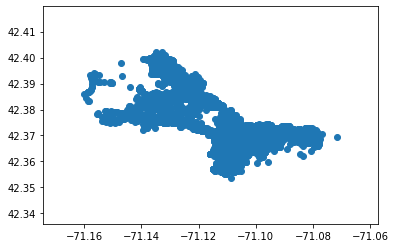

In [52]:
plt.scatter(tickets['lon'],tickets['lat'])

I'm using the same approach as before for finding the building identifier. The code itself is in build_features.py.

Loading the labels:

In [56]:
complaintsH = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/interim/historic_complaints_label.csv')


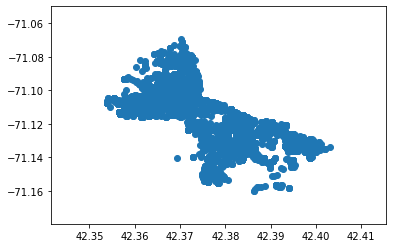

In [57]:
plt.scatter(complaintsH['lat'],complaintsH['lon'])

In [59]:
complaintsH

,Unnamed: 0,Building ID,Unnamed: 0.1,date,identifier,label,lat,lon
0,3656,225-9,3656.0,2014-02-18,285.0,1.0,42.3758,-71.1304
1,2526,336-1,2526.0,2013-12-18,473.0,1.0,42.3784,-71.1110
2,5266,507-35,5266.0,2014-02-10,175.0,1.0,42.3807,-71.1419
3,11323,665-6,11323.0,2012-01-23,506.0,1.0,42.3627,-71.1084
4,10699,645-8,10699.0,2015-02-17,474.0,1.0,42.3753,-71.1112
...,...,...,...,...,...,...,...,...
4849,8336,87-39,8336.0,2015-02-20,611.0,1.0,42.3703,-71.0961
4850,8580,109-7,8580.0,2015-02-27,506.0,1.0,42.3643,-71.1076
4851,4106,437-13,4106.0,2015-03-07,96.0,1.0,42.3757,-71.1517
4852,11490,671-26,11490.0,2013-02-15,303.0,1.0,42.3959,-71.1284


### New Complaints: Commonwealth_Connect_Service_Requests.csv 

These are the 311 complaints from 2016-2019. The data receives much the same cleaning and reformatting as above, I read the labels file and plot the labels here:

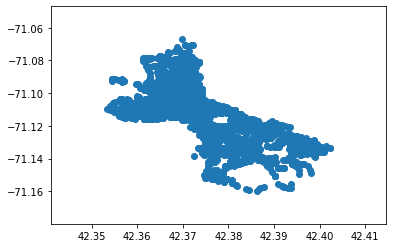

In [61]:
complaints = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/external/Commonwealth_Connect_Service_Requests.csv')
complaints = complaints[complaints['issue_type']=='Icy or Unshoveled Sidewalk']
complaints['lat']= complaints['lat'].astype('float')
complaints['lon'] = complaints['lng'].astype('float')

plt.scatter(complaints['lat'],complaints['lon'])

In [62]:
complaints

,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,lon
19,3211993,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy or Unshoveled Sidewalk,02/22/2017 02:18:28 PM,02/15/2017 03:43:45 PM,02/22/2017 02:18:28 PM,"27 Western Avenue Cambridge, MA",42.365244,-71.106128,"(42.3652438914, -71.1061284509)",NaN,-71.106128
79,3204837,Cambridge,Icy or Unshoveled Sidewalk,closed,"Resident states lots of ""rubble"" was pushed on...",02/22/2017 02:23:01 PM,02/13/2017 09:19:29 AM,02/22/2017 02:23:01 PM,"Pine Street Cambridge, MA",42.365203,-71.097903,"(42.3652029, -71.0979028)",NaN,-71.097903
80,3268761,Cambridge,Icy or Unshoveled Sidewalk,closed,"Barely passable due to icy condition, forcing ...",09/27/2018 03:04:22 AM,03/15/2017 10:28:51 AM,09/27/2018 03:04:22 AM,"153 Erie Cambridge, Massachusetts",42.359672,-71.106540,"(42.3596718, -71.1065401)",NaN,-71.106540
100,2180283,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,01/25/2016 01:42:50 PM,01/25/2016 07:00:02 AM,01/25/2016 01:42:50 PM,"278-304 Huron Ave Cambridge, MA 02138, USA",42.381380,-71.135718,"(42.3813798765, -71.1357181712)",NaN,-71.135718
101,2180717,Cambridge,Icy or Unshoveled Sidewalk,closed,Vacant house - s/w is never shoveled or sanded.,01/26/2016 12:55:54 PM,01/25/2016 09:28:32 AM,01/26/2016 12:55:54 PM,"16 Frances Ave Cambridge, Massachusetts",42.378364,-71.111770,"(42.3783636, -71.1117697)",NaN,-71.111770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46237,7249069,Cambridge,Icy or Unshoveled Sidewalk,open,NaN,NaN,01/22/2020 09:20:31 AM,01/22/2020 08:26:44 PM,"89 Sciarappa St Cambridge, MA, 02141, USA",42.369426,-71.082094,"(42.369426, -71.0820945)",https://seeclickfix.com/files/issue_images/016...,-71.082094
46239,7249052,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy or Unshoveled Sidewalk,01/22/2020 08:02:08 PM,01/22/2020 09:15:43 AM,01/22/2020 08:02:08 PM,"60 Kirkland St Cambridge, MA, 02138, USA",42.377130,-71.110769,"(42.37713, -71.1107685)",NaN,-71.110769
46240,7248705,Cambridge,Icy or Unshoveled Sidewalk,open,Sidewalk very icy. Additionally hampered by tr...,NaN,01/22/2020 08:05:59 AM,01/22/2020 08:26:44 PM,33-35 Howard St Cambridge 02139 United States,42.365078,-71.110978,"(42.3650783, -71.1109776)",https://seeclickfix.com/files/issue_images/016...,-71.110978
46241,7249320,Cambridge,Icy or Unshoveled Sidewalk,open,the sidewalk adjacent to the fenced backyard/p...,NaN,01/22/2020 10:07:37 AM,01/22/2020 08:26:42 PM,"16 Bristol St Cambridge, MA 02141美国",42.367908,-71.091538,"(42.3679081681, -71.0915382206)",NaN,-71.091538


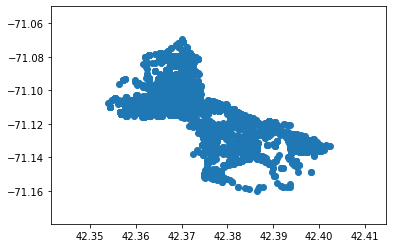

In [63]:
complaints = pd.read_csv('/Users/nbechor/Insight/SlipperySlope/data/interim/Complaints_label.csv')
plt.scatter(complaints['lat'],complaints['lon'])

### Merging the 3 datasets

In [94]:
# some cleaning:
fields = ['Unnamed: 0','Unnamed: 0.1']
complaints=complaints.drop(columns=fields)
tickets = tickets_feature.drop(columns=fields)
complaintsH = complaintsH.drop(columns=fields)

In [121]:
label_1_data = tickets.merge(complaintsH,how='outer',on=['Building ID','date','label','identifier','lat','lon'])
label_1_data = label_1_data.merge(complaints,how='outer',on=['Building ID','date','label','identifier','lat','lon'])

label_1_data


,Building ID,date,identifier,label,lat,lon
0,329-19,2011-02-25,285.0,1.0,42.3761,-71.1309
1,97-21,2011-02-07,480.0,1.0,42.3620,-71.1107
2,97-21,2011-02-07,480.0,1.0,42.3620,-71.1107
3,457-11,2013-02-14,610.0,1.0,42.3742,-71.0955
4,623-19,2008-02-26,417.0,1.0,42.3823,-71.1161
...,...,...,...,...,...,...
14740,267-3,2020-01-22,199.0,1.0,42.3875,-71.1390
14741,71-3,2020-01-22,747.0,1.0,42.3694,-71.0820
14742,623-25,2020-01-22,473.0,1.0,42.3775,-71.1109
14743,714-4,2020-01-22,478.0,1.0,42.3651,-71.1109


In [122]:
label_1_data = label_1_data.drop_duplicates()
label_1_data

,Building ID,date,identifier,label,lat,lon
0,329-19,2011-02-25,285.0,1.0,42.3761,-71.1309
1,97-21,2011-02-07,480.0,1.0,42.3620,-71.1107
3,457-11,2013-02-14,610.0,1.0,42.3742,-71.0955
4,623-19,2008-02-26,417.0,1.0,42.3823,-71.1161
7,337-32,2010-12-29,748.0,1.0,42.3671,-71.0817
...,...,...,...,...,...,...
14740,267-3,2020-01-22,199.0,1.0,42.3875,-71.1390
14741,71-3,2020-01-22,747.0,1.0,42.3694,-71.0820
14742,623-25,2020-01-22,473.0,1.0,42.3775,-71.1109
14743,714-4,2020-01-22,478.0,1.0,42.3651,-71.1109


### Conclusion
Even though there were 6545 tickets, 3535 complaints, and 4854 historic complaints, the sum of all together is less then 14934, because many of the complaints also received tickets (aka overlapping data). Apparently, though, there are almost twice as many complaints as there are tickets. This may indicate that some of the complaints were not worthy of a ticket by the time the inspector arrived, or that the city was unable to verify all the complaints. It's probably a combination of both. 

For now, I'm only using the tickets data as verified labels. If these turn out to be insufficinet, I'll add the complaints data!!